In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.neighbors import LocalOutlierFactor

In [16]:
df = pd.read_csv("Per 36 Minutes.csv")  # 파일명 맞게 수정
df.head()

,season,lg,player,player_id,age,team,pos,g,gs,mp,...,ft_percent,orb_per_36_min,drb_per_36_min,trb_per_36_min,ast_per_36_min,stl_per_36_min,blk_per_36_min,tov_per_36_min,pf_per_36_min,pts_per_36_min
0,2026,NBA,Steven Adams,adamsst01,32.0,HOU,C,4,2.0,98,...,0.917,8.8,7.0,15.8,2.2,1.5,0.7,2.2,3.7,11.4
1,2026,NBA,Bam Adebayo,adebaba01,28.0,MIA,C,5,5.0,168,...,0.889,1.5,8.4,9.9,3.0,0.6,0.2,3.0,2.1,24.6
2,2026,NBA,Ochai Agbaji,agbajoc01,25.0,TOR,SG,6,0.0,90,...,0.625,0.8,5.2,6.0,2.4,2.0,0.4,0.8,4.8,8.0
3,2026,NBA,Santi Aldama,aldamsa01,25.0,MEM,PF,6,0.0,144,...,0.167,3.5,8.5,12.0,3.7,2.3,1.0,2.0,2.5,15.5
4,2026,NBA,Nickeil Alexander-Walker,alexani01,27.0,ATL,SG,6,3.0,182,...,0.842,1.0,2.4,3.4,3.8,1.8,1.0,1.6,1.4,20.2


In [18]:
# Player, Season 등 식별용 ID
id_cols = ["Player", "Season"]

# 숫자형 컬럼 자동 선택
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols

['season',
 'age',
 'g',
 'gs',
 'mp',
 'fg_per_36_min',
 'fga_per_36_min',
 'fg_percent',
 'x3p_per_36_min',
 'x3pa_per_36_min',
 'x3p_percent',
 'x2p_per_36_min',
 'x2pa_per_36_min',
 'x2p_percent',
 'e_fg_percent',
 'ft_per_36_min',
 'fta_per_36_min',
 'ft_percent',
 'orb_per_36_min',
 'drb_per_36_min',
 'trb_per_36_min',
 'ast_per_36_min',
 'stl_per_36_min',
 'blk_per_36_min',
 'tov_per_36_min',
 'pf_per_36_min',
 'pts_per_36_min']

In [20]:
X = df[num_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
import numpy as np

print("NaN 개수:", np.isnan(X_scaled).sum())


NaN 개수: 71099


In [28]:
# 1) 숫자형 컬럼만 추출해서 NaN / inf 처리
X_num = df[num_cols].copy()

# inf, -inf 를 NaN 으로 바꾸기
X_num = X_num.replace([np.inf, -np.inf], np.nan)

# 한 행이라도 NaN 있으면 그 행 전체 제거
mask = ~X_num.isna().any(axis=1)
X_num_clean = X_num[mask]
df_clean = df[mask].reset_index(drop=True)

print("원래 행 수:", df.shape[0])
print("NaN 제거 후 행 수:", df_clean.shape[0])

# 2) 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num_clean.values)

원래 행 수: 31951
NaN 제거 후 행 수: 20040


사용할 ID 컬럼: []


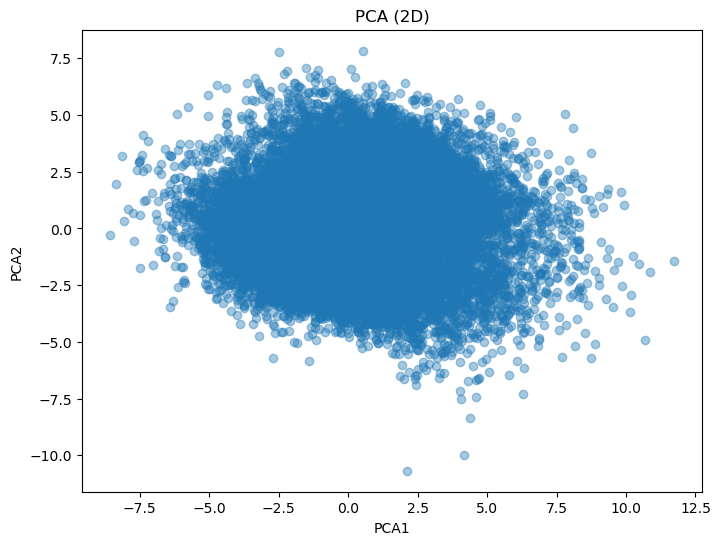

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# df_clean 안에 실제로 존재하는 ID 컬럼만 사용
candidate_ids = ["Player", "Season"]
id_cols = [c for c in candidate_ids if c in df_clean.columns]
print("사용할 ID 컬럼:", id_cols)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# PCA 결과 DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])

# ID 컬럼이 있으면 붙이고, 없으면 PCA만 사용
if len(id_cols) > 0:
    pca_df = pd.concat([df_clean[id_cols].reset_index(drop=True), pca_df], axis=1)

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(pca_df["PCA1"], pca_df["PCA2"], alpha=0.4)
plt.title("PCA (2D)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

In [45]:
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

# 1) LOF 계산
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
_ = lof.fit_predict(X_scaled)
lof_factor = -lof.negative_outlier_factor_

df_lof = df_clean.copy()
df_lof["LOF"] = lof_factor

# 2) Top 5 outliers 추출
top_outliers = df_lof.sort_values("LOF", ascending=False).head(5)

# df_lof 안에 실제 어떤 컬럼이 있는지 확인 (한번만 보는 용도)
print("컬럼들:", df_lof.columns.tolist())

# 3) ID 컬럼(있는 것만 사용)
candidate_ids = ["Player", "player", "player_name", "Season", "season", "player_id", "pos"]
id_cols = [c for c in candidate_ids if c in df_lof.columns]

print("\n=== Top 5 Outliers (Full Rows) ===")
if len(id_cols) > 0:
    print(top_outliers[id_cols + ["LOF"]])
else:
    print(top_outliers[["LOF"]])

컬럼들: ['season', 'lg', 'player', 'player_id', 'age', 'team', 'pos', 'g', 'gs', 'mp', 'fg_per_36_min', 'fga_per_36_min', 'fg_percent', 'x3p_per_36_min', 'x3pa_per_36_min', 'x3p_percent', 'x2p_per_36_min', 'x2pa_per_36_min', 'x2p_percent', 'e_fg_percent', 'ft_per_36_min', 'fta_per_36_min', 'ft_percent', 'orb_per_36_min', 'drb_per_36_min', 'trb_per_36_min', 'ast_per_36_min', 'stl_per_36_min', 'blk_per_36_min', 'tov_per_36_min', 'pf_per_36_min', 'pts_per_36_min', 'LOF']

=== Top 5 Outliers (Full Rows) ===
                  player  season  player_id pos       LOF
15276  Darrell Armstrong    1995  armstda01  PG  3.189919
2265          Paris Bass    2022   basspa01  SF  2.817595
4458      Terrence Jones    2019  joneste01  PF  2.793384
15096      Howard Nathan    1996  nathaho01  PG  2.639403
16855       Dan Godfread    1991  godfrda01   C  2.551699


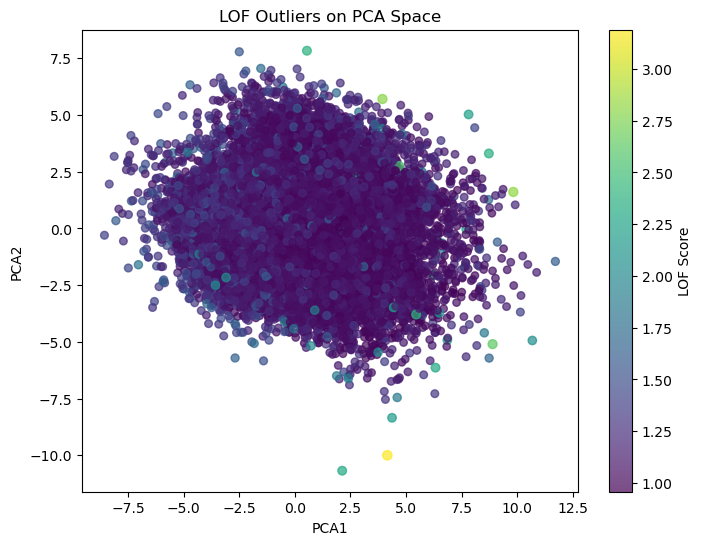

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=20 + df_lof["LOF"] * 8,
    c=df_lof["LOF"],
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(label="LOF Score")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("LOF Outliers on PCA Space")
plt.show()

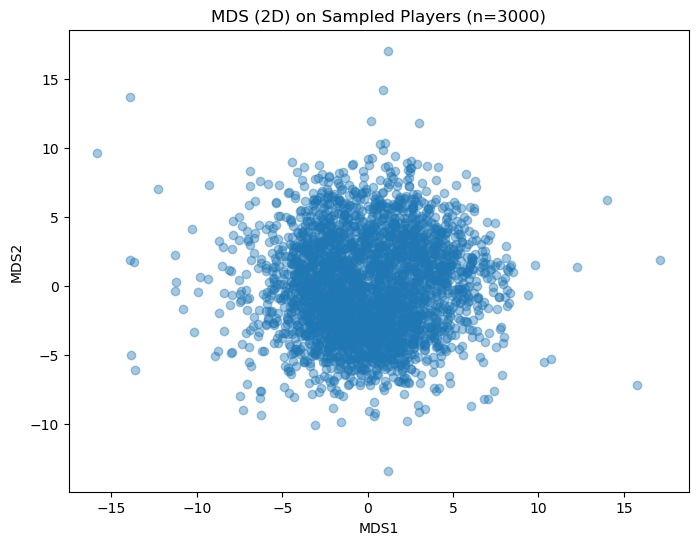

In [42]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import pandas as pd

# 1) MDS는 계산량이 커서 샘플링해서 사용 (예: 3000개)
n_sample = 3000
n_total = X_scaled.shape[0]

np.random.seed(0)
sample_idx = np.random.choice(n_total, size=n_sample, replace=False)

X_sample = X_scaled[sample_idx]
df_sample = df_clean.iloc[sample_idx].reset_index(drop=True)

# 2) MDS 실행 (조금 더 가볍게: n_init=1, max_iter=100)
mds = MDS(
    n_components=2,
    random_state=0,
    dissimilarity="euclidean",
    n_init=1,
    max_iter=100
)
X_mds = mds.fit_transform(X_sample)

mds_df = pd.DataFrame(X_mds, columns=["MDS1", "MDS2"])

# 3) 시각화
plt.figure(figsize=(8,6))
plt.scatter(mds_df["MDS1"], mds_df["MDS2"], alpha=0.4)
plt.title("MDS (2D) on Sampled Players (n=3000)")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.show()
